### Install SECANT from GitHub
##### - Before running, make sure runtime has been set to GPU

In [1]:
!pip install git+https://github.com/tarot0410/SECANT.git -q

### Import packages

In [2]:
from SECANT import SECANT as SE
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
import time
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

### Functions for data simulation and assessing performance

In [3]:
# Function for simulating data 
def simulateData(N, tauVec_sim_ls, muMtx_sim, scale3D_sim, random_seed):
    torch.manual_seed(random_seed) 
    np.random.seed(random_seed)

    K = len(tauVec_sim_ls)
    n_vec = dist.Multinomial(N, torch.tensor(tauVec_sim_ls)).sample()
    n_vec = list(map(int, n_vec.tolist()))
    
    # Generate data from MVN
    mvn_vec = [dist.MultivariateNormal(loc = muMtx_sim[i], scale_tril=scale3D_sim[i]) for i in range(K)]
    X = mvn_vec[0].sample(sample_shape = torch.Size([n_vec[0]]))
    for i in range(1, K):
        X0 = mvn_vec[i].sample(sample_shape = torch.Size([n_vec[i]]))
        X = torch.cat((X,X0), 0)

    # Generate true cluster label 
    clusterLbl_np = np.repeat(np.arange(K), n_vec)

    return X, clusterLbl_np, n_vec

def genADTLbl(con_config, n_vec, p_un, N):
    # Generate true label 
    nCls = len(con_config) 
    nCls_sub = [sum(n_vec[0:con_config[0]])]
    temp_start = con_config[0]
    for i in range(1, nCls):
        nCls0 = con_config[i]
        nCls_sub.append(sum(n_vec[temp_start:(temp_start+nCls0)]))
        temp_start += nCls0

    cls_np = np.repeat(np.arange(nCls), nCls_sub) 
    flip_ind = np.random.binomial(1, p_un, N)
    cls_np[flip_ind==1] = nCls
    return cls_np

def runSimOne(N, p_un_ls, tauVec_sim_ls, muMtx_sim, scale3D_sim, con_config, random_seed):
    data0, clusterLbl_np, n_vec = simulateData(N, tauVec_sim_ls, muMtx_sim, scale3D_sim, random_seed)
    data0_cpu = data0.cpu()
    K = sum(con_config)

    outLS_ARI = [None] * (len(p_un_ls)+2)
    outLS_AMI = outLS_ARI.copy()

    # Run new method (0, one data case)
    for i in range(len(p_un_ls)):
        p_un = p_un_ls[i]
        cls_np = genADTLbl(con_config, n_vec, p_un, N)
        cls_tt = torch.tensor(cls_np, device = device)

        uncertainLbl = True
        if p_un == 0:
            uncertainLbl = False
        SE_rslt = SE.SECANT_CITE(data0, con_config, cls_tt, uncertain=uncertainLbl)
        lbl_out = SE_rslt.lbl
        outLS_ARI[i]= adjusted_rand_score(lbl_out.cpu().numpy(), clusterLbl_np)
        outLS_AMI[i]= adjusted_mutual_info_score(lbl_out.cpu().numpy(), clusterLbl_np)

    # Run GMM
    gmm = GaussianMixture(n_components=K, random_state=random_seed).fit(data0_cpu)
    gmm_lbl = gmm.predict(data0_cpu)
    outLS_ARI[4] = adjusted_rand_score(gmm_lbl, clusterLbl_np)
    outLS_AMI[4] = adjusted_mutual_info_score(gmm_lbl, clusterLbl_np)
    
    # Run Kmeans
    np.random.seed(random_seed)
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(data0_cpu)
    kmeans_labels = kmeans.predict(data0_cpu)
    outLS_ARI[5] = adjusted_rand_score(kmeans_labels, clusterLbl_np)
    outLS_AMI[5] = adjusted_mutual_info_score(kmeans_labels, clusterLbl_np)

    return outLS_ARI, outLS_AMI 

def runSimFull(N, p_un_ls, tauVec_sim_ls, muMtx_sim, scale3D_sim, con_config, nSim = 100):
    mtxARI = np.zeros((nSim, len(p_un_ls)+2))
    mtxAMI = np.zeros((nSim, len(p_un_ls)+2))
    for i in range(nSim):
        outLS_ARI, outLS_AMI = runSimOne(N, p_un_ls, tauVec_sim_ls, muMtx_sim, scale3D_sim, con_config, random_seed = i*10)
        mtxARI[i,] = outLS_ARI
        mtxAMI[i,] = outLS_AMI
    return mtxARI, mtxAMI

### Run simulations for varying number of clusters (K) scenario

In [4]:
N = 1000 # Sample size
p_un_ls = [0., 0.2, 0.4, 0.6] # Uncertain rate in ADT label

##### Need to link Google Drive and copy files in "simulation_files" folder

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Scenario 1: 8 clusters

In [6]:
K = 8
sim_config = [2,1,3,1,1]

startTime = time.perf_counter()

muMtx_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/muMtx_D10_K' + str(K) + '.pt').to(device)
scale3D_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/scale3D_D10_K' + str(K) + '.pt').to(device)
wgt_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/wgt_D10_K' + str(K) + '.pt')
tauVec_sim_ls = wgt_sim.cpu().tolist()

mtxARI, mtxAMI = runSimFull(N, p_un_ls, tauVec_sim_ls, muMtx_sim, scale3D_sim, sim_config, nSim = 100)

print('running time {}'.format(time.perf_counter()-startTime)) 

running time 319.084938516


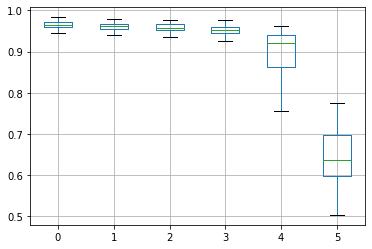

In [7]:
### Plot boxplot 
# 0: SECANT (pU=0); 1: SECANT (pU=0.2); 2: SECANT (pU=0.4); 3: SECANT (pU=0.6); 
# 4: GMM; 5: K-means
logLikMtx_pd = pd.DataFrame(mtxARI)
logLikMtx_pd.boxplot(sym='')

#### Scenario 2: 10 clusters

In [8]:
K = 10
sim_config = [2,2,3,2,1]

startTime = time.perf_counter()

muMtx_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/muMtx_D10_K' + str(K) + '.pt').to(device)
scale3D_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/scale3D_D10_K' + str(K) + '.pt').to(device)
wgt_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/wgt_D10_K' + str(K) + '.pt')
tauVec_sim_ls = wgt_sim.cpu().tolist()

mtxARI, mtxAMI = runSimFull(N, p_un_ls, tauVec_sim_ls, muMtx_sim, scale3D_sim, sim_config, nSim = 100)

print('running time {}'.format(time.perf_counter()-startTime)) 

running time 373.805457227


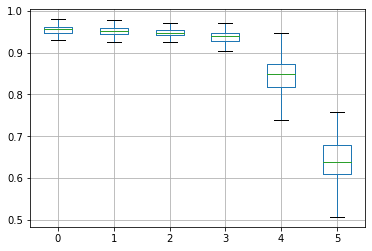

In [9]:
### Plot boxplot 
# 0: SECANT (pU=0); 1: SECANT (pU=0.2); 2: SECANT (pU=0.4); 3: SECANT (pU=0.6); 
# 4: GMM; 5: K-means
logLikMtx_pd = pd.DataFrame(mtxARI)
logLikMtx_pd.boxplot(sym='')

#### Scenario 3: 12 clusters

In [10]:
K = 12
sim_config = [1,3,4,3,1]

startTime = time.perf_counter()

muMtx_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/muMtx_D10_K' + str(K) + '.pt').to(device)
scale3D_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/scale3D_D10_K' + str(K) + '.pt').to(device)
wgt_sim = torch.load('./drive/My Drive/Revision_SECANT/Simulation/wgt_D10_K' + str(K) + '.pt')
tauVec_sim_ls = wgt_sim.cpu().tolist()

mtxARI, mtxAMI = runSimFull(N, p_un_ls, tauVec_sim_ls, muMtx_sim, scale3D_sim, sim_config, nSim = 100)

print('running time {}'.format(time.perf_counter()-startTime)) 

running time 497.22279604799996


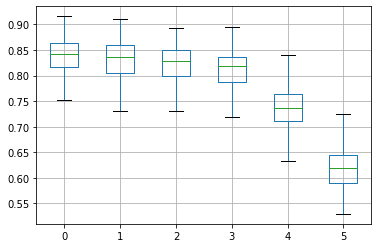

In [11]:
### Plot boxplot 
# 0: SECANT (pU=0); 1: SECANT (pU=0.2); 2: SECANT (pU=0.4); 3: SECANT (pU=0.6); 
# 4: GMM; 5: K-means
logLikMtx_pd = pd.DataFrame(mtxARI)
logLikMtx_pd.boxplot(sym='')